# Tuning the early stopping patience hyperparameter based on 5-fold cross-validation

User c is completely removed as this is the test set.

The remaining users A,B,D,E and F make up each fold.

For example, fold 1 will train on users B,D,E and F then evaluate on A (and so on for each fold).

Choice of model (8-16) justified from "7_CNN_model_comparison.ipynb"
Other hyperparameters chosen from notebook 8.

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [57]:
# Needed to allow editing using PyCharm etc
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [58]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
#     !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/doppler_spectrograms/3/'

HYPERPARAMETER_PATH = BASE_PATH + 'results/CNN_hyperparameter_search/'

RESULTS_PATH = BASE_PATH + 'results/CNN_early_stopping_tuning/'
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
   

In [59]:
SAVE_RESULTS = True
SAVE_GRAPHS = True

Import remaining packages

In [60]:
import numpy as np
import sys
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [61]:
# needed for CheckpointSaver (not in release yet but very useful)
# https://github.com/scikit-optimize/scikit-optimize/issues/678
# ! pip install git+https://github.com/scikit-optimize/scikit-optimize/ 
    
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
from skopt import dump, load
from skopt.plots import plot_objective, plot_evaluations

In [62]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup

In [63]:
target_names = ["walking", "pushing", "sitting", "pulling",
                "circling", "clapping", "bending"]
nb_classes = len(target_names)

# input image dimensions
img_rows, img_cols = 75, 75
# user c excluded as this is reserved for final evaluation
users = ["A", "B", "D", "E", "F"] 

In [64]:
def load_data(user_letter):
    with open(DATA_PATH + user_letter + "_data.pkl", 'rb') as data_file:
        data = pickle.load(data_file)
        data = data.reshape(data.shape[0], 1, 75, 75)
        
    with open(DATA_PATH + user_letter + "_labels.pkl", 'rb') as labels_file:
        labels = pickle.load(labels_file)
        labels = np.reshape(labels, (len(labels), 1))
     
    return data, labels

In [65]:
datasets = {}
for user in users:
    data, labels = load_data(user)
    datasets[user] = {"data":data, "labels":labels}

In [66]:
def split_train_validation(validation_user):
    train_data = []
    train_labels = []
    validation_data = []
    validation_labels = []
    for user in users:
        data = datasets[user]["data"]
        labels = datasets[user]["labels"]
        if user == validation_user:
            validation_data = data
            validation_labels = labels
            
        else:
            train_data.append(data)
            train_labels.append(labels)

    train_labels = np.concatenate(train_labels, axis=0)
    train_data = np.concatenate(train_data, axis=0)
    
    train_labels = np_utils.to_categorical(train_labels, nb_classes)
    validation_labels = np_utils.to_categorical(validation_labels, nb_classes)
    train_data = train_data.astype('float32')
    validation_data = validation_data.astype('float32')
    train_data /= 255
    validation_data /= 255 
    
    return {
        "train_data": train_data,
        "train_labels": train_labels,
        "validation_data": validation_data,
        "validation_labels": validation_labels
       }

## Define Model

In [67]:
def make_model(nb_filters, img_rows, img_cols, nb_classes, activation,
               dropout, num_dense_nodes, num_dense_layers,
               kernel_size, pooling_size):
    
    kernel_size = (kernel_size, kernel_size)
    pooling_size = (pooling_size, pooling_size)
    
    model = Sequential(name=nb_filters)
    nb_filters = nb_filters.split("-")
    size_1 = int(nb_filters[0])
    size_2 = int(nb_filters[1])

    model.add(Convolution2D(size_1, kernel_size, padding='same',
                            input_shape=(1, img_rows, img_cols),
                            activation=activation))
    model.add(Convolution2D(size_1, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Convolution2D(size_2, kernel_size, padding='same',
                            activation=activation))
    model.add(Convolution2D(size_2, kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=pooling_size))
    model.add(Dropout(dropout))

    model.add(Flatten())
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

## Hyperparameter Search

### Fixed Parameters

In [68]:
nb_epoch = 100 # large enough to ensure early stopping
# nb_epoch = 1 # testing

### Load gp results

In [69]:
# needed for loading results (objective needs to be defined)
def objective():
    return 0

In [70]:
res_gp = load(HYPERPARAMETER_PATH + "res_gp_complete.pkl")

## Results from hyperparameter search in notebook 8

Best Hyperparameters Discovered

In [71]:
dimensions = ['optimizer', 'learning_rate', 'activation', 'dropout',
              'num_dense_nodes', 'num_dense_layers', 'kernel_size',
              'pooling_size','batch_size']
parameters = res_gp.x
for index, parameter in enumerate(parameters):
    print(dimensions[index] + ":", parameter)

optimizer: adam
learning_rate: 0.0012375685948764468
activation: relu
dropout: 0.597428888669298
num_dense_nodes: 1024
num_dense_layers: 3
kernel_size: 3
pooling_size: 2
batch_size: 576


In [72]:
early_stopping_patience = np.arange(-1,11)

In [73]:
results = {}
for patience in early_stopping_patience:
    results[str(patience)] = {}
    for user in users:
        results[str(patience)][user] = {}

In [76]:
for patience in early_stopping_patience:
    print("Patience:", patience)
    average_accuracy = 0
    average_loss = 0
    average_stopped_epoch = 0
    for user in users:
        print("User:", user)
        data_split = split_train_validation(user)
        train_data = data_split["train_data"]
        train_labels = data_split["train_labels"]
        validation_data = data_split["validation_data"]
        validation_labels = data_split["validation_labels"]

        model = make_model("8-16", img_rows, img_cols, nb_classes, parameters[2],
                       parameters[3], parameters[4], parameters[5],
                       parameters[6], parameters[7])
        
        optimizer = parameters[0] 
        learning_rate = parameters[1]
        if optimizer == 'adam':
            selected_optimizer = Adam(lr=learning_rate)
            
        elif optimizer == 'sgd_standard':
            selected_optimizer = SGD(lr=learning_rate)
            
        else:
            #nestrov momentum
            selected_optimizer = SGD(lr=learning_rate, decay=1e-6, 
                                     momentum=0.9, nesterov=True)
            
        model.compile(loss='categorical_crossentropy',
                      optimizer=selected_optimizer,
                      metrics=['accuracy'])

        callback_list = []
        early_stopping = None
        # -1 used to represent no early stopping
        if patience != -1:
            early_stopping = EarlyStopping(monitor='val_acc', patience=patience)
            callback_list.append(early_stopping)
        
        
        model.fit(
            train_data,
            train_labels,
            validation_data=(validation_data, validation_labels),
            batch_size=parameters[8],
            epochs=nb_epoch,
            shuffle=True, 
            callbacks=callback_list,
            verbose=0)
        
        if early_stopping is not None:
            print("Epoch Stopped:", early_stopping.stopped_epoch)
            results[str(patience)][user]["stopped_epoch"] = early_stopping.stopped_epoch
            average_stopped_epoch += early_stopping.stopped_epoch

        else:
            print("Epoch Stopped:", nb_epoch)
            results[str(patience)][user]["stopped_epoch"] = nb_epoch
            average_stopped_epoch += nb_epoch


        evaluation = model.evaluate(validation_data, validation_labels,
                                    batch_size=parameters[8], verbose=0)
        
        results[str(patience)][user]["loss"] = evaluation[0]
        results[str(patience)][user]["accuracy"] = evaluation[1]

        average_loss += evaluation[0]
        average_accuracy += evaluation[1]
        K.clear_session()

    print("Average Accuracy:", average_accuracy/len(users))
    print("Average Epoch Stopped:", average_stopped_epoch/len(users))
    results[str(patience)]["avg_loss"] = average_loss/len(users)
    results[str(patience)]["avg_acc"] = average_accuracy/len(users)
    results[str(patience)]["avg_epoch_stopped"] = average_stopped_epoch/len(users)

Patience: -1
User: A
Train on 29019 samples, validate on 7966 samples
Epoch 1/1
29019/29019 [==============================] - 39s 1ms/step - loss: 1.2314 - acc: 0.4988 - val_loss: 0.7000 - val_acc: 0.7812
0.15623901542215352
Patience: 0
User: A
Train on 29019 samples, validate on 7966 samples
Epoch 1/1
29019/29019 [==============================] - 39s 1ms/step - loss: 1.1588 - acc: 0.5393 - val_loss: 0.7596 - val_acc: 0.6560
0.13120763195898855
Patience: 1
User: A
Train on 29019 samples, validate on 7966 samples
Epoch 1/1
29019/29019 [==============================] - 39s 1ms/step - loss: 1.2485 - acc: 0.4968 - val_loss: 0.8752 - val_acc: 0.6157
0.12314838111744794
Patience: 2
User: A
Train on 29019 samples, validate on 7966 samples
Epoch 1/1
29019/29019 [==============================] - 39s 1ms/step - loss: 1.2483 - acc: 0.4977 - val_loss: 0.7860 - val_acc: 0.7499
0.1499874474271709
Patience: 3
User: A
Train on 29019 samples, validate on 7966 samples
Epoch 1/1
29019/29019 [========

### Save results

In [42]:
if SAVE_RESULTS:
    with open(RESULTS_PATH + "results_dictionary.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

### Load Results

In [43]:
with open(RESULTS_PATH + "results_dictionary.pkl", 'rb') as results_file:
    results = pickle.load(results_file)

## Visualize Results

### Average Accuracy

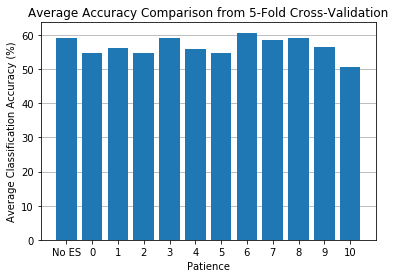

In [53]:
accuracies = []
labels = []
for patience, value in results.items():
    accuracies.append(value["avg_acc"])
    if patience == "-1":
        labels.append("No ES")
    else:
        labels.append(patience)
    
plt.bar(range(len(labels)), np.array(accuracies)*100, zorder=3)
plt.xticks(range(len(labels)), labels)
plt.xlabel("Patience")
plt.ylabel("Average Classification Accuracy (%)")
plt.title("Average Accuracy Comparison from 5-Fold Cross-Validation")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS:
    plt.savefig(RESULTS_PATH + "average_accuracy_comparison.pdf", format='pdf')
plt.show()

### Average Loss

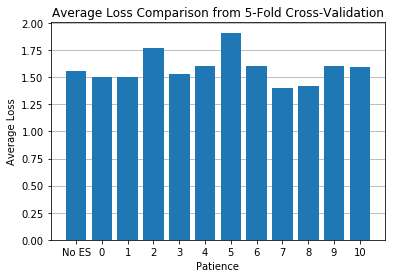

In [54]:
loss = []
labels = []
for patience, value in results.items():
    loss.append(value["avg_loss"])
    if patience == "-1":
        labels.append("No ES")
    else:
        labels.append(patience)
    
plt.bar(range(len(labels)), loss, zorder=3)
plt.xticks(range(len(labels)), labels)
plt.xlabel("Patience")
plt.ylabel("Average Loss")
plt.title("Average Loss Comparison from 5-Fold Cross-Validation")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS:
    plt.savefig(RESULTS_PATH + "average_loss_comparison.pdf", format='pdf')
plt.show()

### Average Epoch Stopped At

In [ ]:
stopped = []
labels = []
for patience, value in results.items():
    stopped.append(value["avg_epoch_stopped"])
    if patience == "-1":
        labels.append("No ES")
    else:
        labels.append(patience)
    
plt.bar(range(len(labels)), stopped, zorder=3)
plt.xticks(range(len(labels)), labels)
plt.xlabel("Patience")
plt.ylabel("Average Epoch Stopped At")
plt.title("Average Epoch Stopped at Comparison from 5-Fold Cross-Validation")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS:
    plt.savefig(RESULTS_PATH + "average_stopped_epoch_comparison.pdf", format='pdf')
plt.show()

### Box Plot Comparison

In [55]:
seperated_results = {}
for patience, value in results.items():
    accuracies = []
    for user_label, res in value.items():
        if len(user_label) > 1:
            continue
        accuracies.append(res["accuracy"] * 100)
        
    if patience == "-1":
        seperated_results["No ES"] = accuracies

    else:
        seperated_results[patience] = accuracies

labels = []
for patience in early_stopping_patience:
    if patience == -1:
        labels.append("No ES")
    else:
        labels.append(str(patience))
data_to_plot = []
for label in labels:
    data_to_plot.append(seperated_results[label])

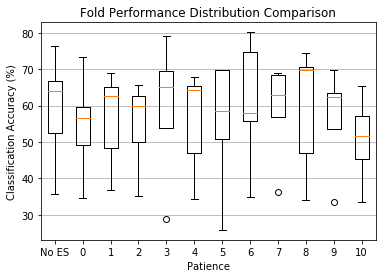

In [56]:
plt.boxplot(data_to_plot, labels=labels, zorder=3)
plt.title("Fold Performance Distribution Comparison")
plt.xlabel("Patience")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS:
     plt.savefig(RESULTS_PATH + "boxplot.pdf", format='pdf')